# Combining weather data and ratings data

In [2]:
import pandas as pd

# Load the two CSV files
weather_df = pd.read_csv('weather_data_final')
ratings_df = pd.read_csv('ratings_final')

# Convert both date columns to datetime format to ensure they match during merging
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], format='%Y-%m-%d')
ratings_df['Date'] = pd.to_datetime(ratings_df['Date'], format='%Y-%m-%d')

# Perform a left join to keep all ratings even if there are duplicates for a single date
merged_df = pd.merge(ratings_df, weather_df, left_on='Date', right_on='timestamp', how='left')

# Drop the redundant 'Date' column after merging
merged_df = merged_df.drop(columns=['Date'])

# Sort the DataFrame by date, with the newest dates at the top
merged_df = merged_df.sort_values(by='timestamp', ascending=False).reset_index(drop=True)

# Drop missing values
merged_df = merged_df.dropna()

# Sort the DataFrame by date, with the newest dates at the top
merged_df = merged_df.sort_values(by='timestamp', ascending=False).reset_index(drop=True)

merged_df.to_csv('data_final', index=False)

merged_df

FileNotFoundError: [Errno 2] No such file or directory: 'weather_data_final'

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

df_final = pd.read_csv('/Users/jvander/Desktop/data_final.csv')
df_final

,Rating,timestamp,station,temp_dry,precip_dur_past10min,sun_last10min_glob
0,5,2024-08-20,6116.0,22.8,0.0,364.0
1,5,2024-08-19,6116.0,19.9,0.0,584.0
2,5,2024-08-19,6116.0,19.9,0.0,584.0
3,1,2024-08-19,6116.0,19.9,0.0,584.0
4,5,2024-08-19,6116.0,19.9,0.0,584.0
...,...,...,...,...,...,...
3106,3,2021-01-30,6116.0,-0.7,0.0,443.0
3107,5,2021-01-18,6116.0,3.1,72.0,0.0
3108,5,2021-01-04,6116.0,2.2,0.0,148.0
3109,5,2021-01-02,6116.0,1.3,0.0,0.0


# OLS 


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [5]:
# We want to exclude timestamp 
# Split the data into a 70% training set and a 30% testing set
train_data, test_data = train_test_split(df_final, test_size=0.3, random_state=69)

data = train_data

#Display the data used for training
data

,Rating,timestamp,station,temp_dry,precip_dur_past10min,sun_last10min_glob
1716,5,2023-04-08,6116.0,10.7,1440.0,0.0
1556,5,2023-06-28,6116.0,19.0,1430.0,0.0
2319,5,2022-07-04,6116.0,18.6,6.0,425.5
2567,3,2022-03-12,6116.0,8.9,0.0,541.0
2449,1,2022-05-12,6116.0,14.2,7.0,563.5
...,...,...,...,...,...,...
278,1,2024-07-05,6116.0,15.8,34.0,587.0
2452,5,2022-05-11,6116.0,14.0,118.0,32.5
439,2,2024-06-04,6116.0,16.4,46.0,113.0
1626,1,2023-05-13,6116.0,19.6,1440.0,0.0


In [6]:
# List of variables to remove iteratively
variables_to_remove = ['Rating', 'timestamp', 'station']

# Prepare the features (X) and the label (y)
X = data.drop(variables_to_remove, axis=1)
y = data['Rating']  # Labels (the 'Monthly rent' column)

# Add a constant to the features (intercept term)
X = sm.add_constant(X)

# Initialize a list to keep track of removed variables
removed_variables = []

while True:
    # Create an OLS model
    model = sm.OLS(y, X)

    # Fit the OLS model with heteroscedasticity robust errors
    results = model.fit(cov_type='HC3')

    # Find the variable with the highest p-value (least significant)
    max_p_value = results.pvalues.idxmax()
    
    # Check if the highest p-value is above a certain threshold (e.g., 0.10)
    if results.pvalues[max_p_value] > 0.10:
        print(f"Removing '{max_p_value}' (p-value: {results.pvalues[max_p_value]:.4f})")
        X = X.drop(max_p_value, axis=1)
        removed_variables.append(max_p_value)
    else:
        break

# Print the summary of the final regression model
print(results.summary())

# Get the Predicted Values
y_pred = results.predict(X)

# Calculate the Residuals
residuals = y - y_pred

# Calculate the RMSE
RMSE_train_OLS = np.sqrt((residuals ** 2).mean())
print('Train Root Mean Squared Error (RMSE):', round(RMSE_train_OLS,3))

# Print the list of removed variables
print("Removed variables:", removed_variables)


Removing 'temp_dry' (p-value: 0.7918)
Removing 'sun_last10min_glob' (p-value: 0.4786)
                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.749
Date:                Sun, 25 Aug 2024   Prob (F-statistic):             0.0974
Time:                        16:35:58   Log-Likelihood:                -3812.3
No. Observations:                2177   AIC:                             7629.
Df Residuals:                    2175   BIC:                             7640.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

In [7]:
removed = variables_to_remove + removed_variables
# Prepare the features in the test data for the first model
X_test = test_data.drop(removed, axis=1)
X_test = sm.add_constant(X_test)  # Add constant

# Make sure the test data columns match the model's training data columns
X_test = X_test[X.columns]

# True 'Monthly rent' values in the test data
y_test = test_data['Rating']

# Get the Predicted Values on the test data
y_pred_test = results.predict(X_test)

# Calculate the Residuals for the test data
residuals_test = y_test - y_pred_test

# Calculate the RMSE for the test data
RMSE_test_OLS = np.sqrt((residuals_test ** 2).mean())
print('Test Root Mean Squared Error (RMSE) for First Model:', round(RMSE_test_OLS,3))

Test Root Mean Squared Error (RMSE) for First Model: 1.39


# LASSO

Subdata: Best alpha = 0.003
Subdata: Training RMSE = 1.394
Subdata: Test RMSE = 1.39


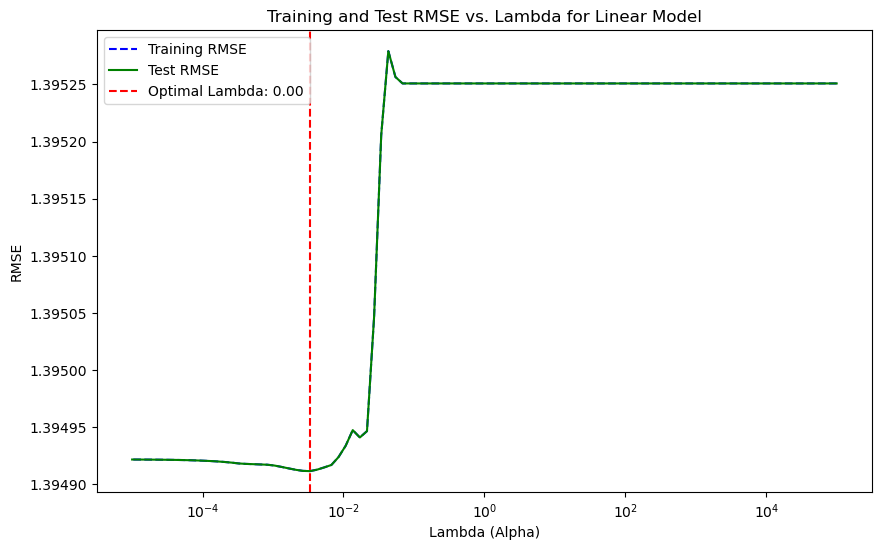

In [12]:
# Subdata preparation
X_sub = df_final.drop(['Rating', 'timestamp', 'station'], axis=1)
y_sub = df_final['Rating']

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.3, random_state=69)

# Scaling the subdata
scaler_sub = StandardScaler().fit(X_train_sub)
X_train_sub_scaled = scaler_sub.transform(X_train_sub)
X_test_sub_scaled = scaler_sub.transform(X_test_sub)

# Manually specify a broader range of alphas
alphas_to_test = np.logspace(-5, 5, 100)

# LASSO with cross-validation on subdata
lasso_cv_sub = LassoCV(alphas=alphas_to_test, cv=10, max_iter=10000)
lasso_cv_sub.fit(X_train_sub_scaled, y_train_sub)

# Predictions
y_pred_train_sub = lasso_cv_sub.predict(X_train_sub_scaled)
y_pred_test_sub = lasso_cv_sub.predict(X_test_sub_scaled)

# RMSE
rmse_train_sub = np.sqrt(mean_squared_error(y_train_sub, y_pred_train_sub))
rmse_test_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_test_sub))

print(f"Subdata: Best alpha = {round(lasso_cv_sub.alpha_,3)}")
print(f"Subdata: Training RMSE = {round(rmse_train_sub,3)}")
print(f"Subdata: Test RMSE = {round(rmse_test_sub,3)}")

# Calculate training RMSE for each alpha
train_mse = np.mean(lasso_cv_sub.mse_path_, axis=1)
train_rmse = np.sqrt(train_mse)

# Calculate test RMSE for each alpha
test_rmse = np.sqrt(lasso_cv_sub.mse_path_.mean(axis=-1))

# Plotting RMSE vs. Lambda
plt.figure(figsize=(10, 6))
plt.plot(lasso_cv_sub.alphas_, train_rmse, label='Training RMSE', color='blue', linestyle='--')
plt.plot(lasso_cv_sub.alphas_, test_rmse, label='Test RMSE', color='green')
plt.axvline(lasso_cv_sub.alpha_, linestyle='--', color='red', label=f'Optimal Lambda: {lasso_cv_sub.alpha_:.2f}')
plt.xscale('log')
plt.xlabel('Lambda (Alpha)')
plt.ylabel('RMSE')
plt.title('Training and Test RMSE vs. Lambda for Linear Model')
plt.savefig("7_RMSE_vs_Lambda_Linear_Without.png")
plt.legend()
plt.show()

Subdata with Polynomial Features: Best alpha = 0.022
Subdata with Polynomial Features: Training RMSE = 1.394
Subdata with Polynomial Features: Test RMSE = 1.389


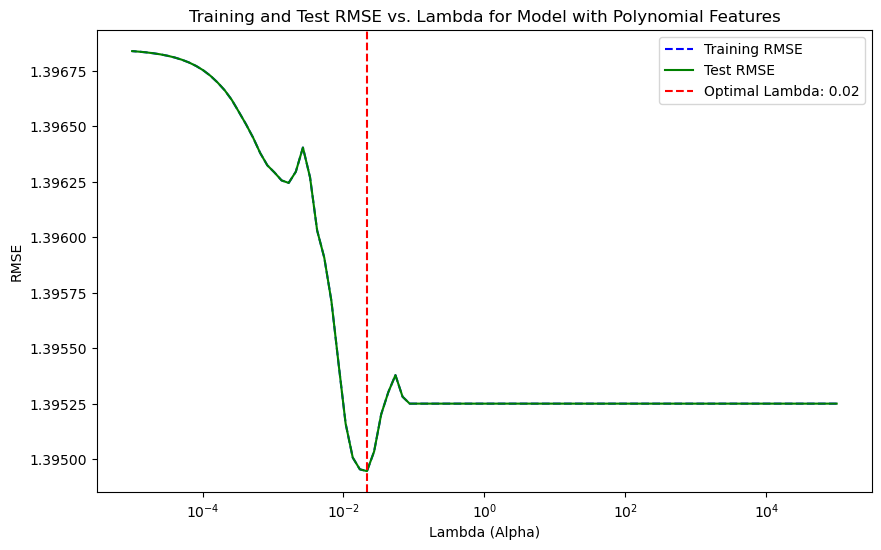

In [13]:
# Subdata preparation
X_sub = df_final.drop(['Rating', 'timestamp', 'station'], axis=1)
y_sub = df_final['Rating']

# Generating polynomial features for subdata
poly_sub = PolynomialFeatures(degree=2, include_bias=False)
X_sub_poly = poly_sub.fit_transform(X_sub)

X_train_sub_poly, X_test_sub_poly, y_train_sub, y_test_sub = train_test_split(X_sub_poly, y_sub, test_size=0.3, random_state=69)

# Scaling the subdata
scaler_sub_poly = StandardScaler().fit(X_train_sub_poly)
X_train_sub_poly_scaled = scaler_sub_poly.transform(X_train_sub_poly)
X_test_sub_poly_scaled = scaler_sub_poly.transform(X_test_sub_poly)

# Manually specify a broader range of alphas
alphas_to_test = np.logspace(-5, 5, 100)

# LASSO with cross-validation on subdata
lasso_cv_sub_poly = LassoCV(alphas=alphas_to_test, cv=10, max_iter=10000)
lasso_cv_sub_poly.fit(X_train_sub_poly_scaled, y_train_sub)

# Predictions
y_pred_train_sub_poly = lasso_cv_sub_poly.predict(X_train_sub_poly_scaled)
y_pred_test_sub_poly = lasso_cv_sub_poly.predict(X_test_sub_poly_scaled)

# RMSE
rmse_train_sub_poly = np.sqrt(mean_squared_error(y_train_sub, y_pred_train_sub_poly))
rmse_test_sub_poly = np.sqrt(mean_squared_error(y_test_sub, y_pred_test_sub_poly))

print(f"Subdata with Polynomial Features: Best alpha = {round(lasso_cv_sub_poly.alpha_,3)}")
print(f"Subdata with Polynomial Features: Training RMSE = {round(rmse_train_sub_poly,3)}")
print(f"Subdata with Polynomial Features: Test RMSE = {round(rmse_test_sub_poly,3)}")

# Calculate training RMSE for each alpha
train_mse_poly = np.mean(lasso_cv_sub_poly.mse_path_, axis=1)
train_rmse_poly = np.sqrt(train_mse_poly)

# Calculate test RMSE for each alpha
test_rmse_poly = np.sqrt(lasso_cv_sub_poly.mse_path_.mean(axis=-1))

# Plotting RMSE vs. Lambda
plt.figure(figsize=(10, 6))
plt.plot(lasso_cv_sub_poly.alphas_, train_rmse_poly, label='Training RMSE', color='blue', linestyle='--')
plt.plot(lasso_cv_sub_poly.alphas_, test_rmse_poly, label='Test RMSE', color='green')
plt.axvline(lasso_cv_sub_poly.alpha_, linestyle='--', color='red', label=f'Optimal Lambda: {lasso_cv_sub_poly.alpha_:.2f}')
plt.xscale('log')
plt.xlabel('Lambda (Alpha)')
plt.ylabel('RMSE')
plt.title('Training and Test RMSE vs. Lambda for Model with Polynomial Features')
plt.legend()
plt.savefig("7_RMSE_vs_Lambda_Poly.png")
plt.show()